<a href="https://colab.research.google.com/github/Fathanhelmi/Twitter-scraping/blob/main/Crawling_Twitter_Kelompok_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tweepy


In [2]:
import tweepy
import pandas as pd
# import gspread
import os

In [3]:

import tweepy
import pandas as pd
# import gspread
import os


# Replace with your actual credentials
consumer_key = "d4m9UVDY29JfNxSBkgRgtVV8k"
consumer_secret = "WOVDKgDGMj4POMrAv6TRPXlkD4gtXVlT67T99pI78qSrQcZJQ1"
access_token = "1990408864047697920-oFWUiSHciYzi5Y7l7QgAf9l1daWwS8"
access_token_secret = "T075M1Zj4hyMoSkLuu8FVjeQYbIWDKaI36OKOTBqI95BA"
bearer_token = "AAAAAAAAAAAAAAAAAAAAAP%2Fp5QEAAAAAiE6%2B4D2dPEK5qZ5wNm5CZi9WCDY%3DrmoD0xEu1oJBu4x6w8Bx4KdEBlaPEmharcVc7m4iStSkbDaQYQ"

try:
    # Authenticate with the Twitter API
    auth = tweepy.OAuth1UserHandler(
        consumer_key,
        consumer_secret,
        access_token,
        access_token_secret,
        bearer_token
    )
    api = tweepy.API(auth)

    # Verify credentials (optional but recommended)
    api.verify_credentials()
    print("Authentication successful!")

except tweepy.TweepyException as e:
    print(f"Error during authentication: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Authentication successful!


In [4]:

import tweepy
import pandas as pd

# --- ---
client = tweepy.Client(bearer_token)

search_query = '(#Whoosh OR #KCIC OR #KeretaCepat OR "Whoosh" OR "KCIC" OR "kereta cepat") lang:id -is:retweet'


try:
    response = client.search_recent_tweets(
        query=search_query,
        max_results=100,
        tweet_fields=["created_at", "lang", "public_metrics"]
    )

    tweets = response.data

    if tweets:
        rows = []
        for tweet in tweets:
            rows.append({
                "tweet_id": tweet.id,
                "created_at": tweet.created_at,
                "lang": tweet.lang,
                "text": tweet.text,
                "retweet_count": tweet.public_metrics.get("retweet_count", 0),
                "reply_count": tweet.public_metrics.get("reply_count", 0),
                "like_count": tweet.public_metrics.get("like_count", 0),
                "quote_count": tweet.public_metrics.get("quote_count", 0),
            })

        df = pd.DataFrame(rows)
        print("Jumlah tweet:", len(df))
        print(df.head())
    else:
        print("Found 0 tweets.")
        df = pd.DataFrame()  # biar variabel df tetap ada

except tweepy.TweepyException as e:
    print(f"Error during tweet search: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Jumlah tweet: 100
              tweet_id                created_at lang  \
0  1990411250153537779 2025-11-17 13:26:36+00:00   in   
1  1990411152606540214 2025-11-17 13:26:13+00:00   in   
2  1990410892714934530 2025-11-17 13:25:11+00:00   in   
3  1990410336264954153 2025-11-17 13:22:58+00:00   in   
4  1990410250566963456 2025-11-17 13:22:38+00:00   in   

                                                text  retweet_count  \
0  Dirut KCIC soal Utang Whoosh: Kita Serahkan ke...              0   
1  @DS_yantie Tidak akan mau. Dia sadar butuh kon...              0   
2  @afannni @Strategi_Bisnis hhehe.... mestinya k...              0   
3  @ichannasution Selamat malam Kak. Mohon maaf m...              0   
4  @Galihholic_87 @Zeefire02 Eh termul brengsek k...              0   

   reply_count  like_count  quote_count  
0            1           0            0  
1            0           0            0  
2            0           0            0  
3            1           0            0  
4 

In [9]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL SENTIMEN MULTILINGUAL ROBERTA
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)
model.eval()

id2label = {0: "negative", 1: "neutral", 2: "positive"}

def indo_roberta_sentiment(text, max_length=128):
    if not isinstance(text, str) or text.strip() == "":
        return "neutral", 0.0

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=max_length
    ).to(device)

    with torch.no_grad():
        logits = model(**inputs).logits

    probs = softmax(logits, dim=1).cpu().numpy()[0]
    idx = probs.argmax()
    return id2label[idx], float(probs[idx])


In [10]:
from tqdm.auto import tqdm

translated_texts = []
evaluations = []
probs = []

for text in tqdm(df["text"], desc="Analyse", position=0, leave=True):

    label, prob = indo_roberta_sentiment(text)
    evaluations.append(label)
    probs.append(prob)

df["Evaluation"] = evaluations
df["Prob"] = probs

if "created_at" in df.columns:
    df_final = df.sort_values("created_at").reset_index(drop=True)
else:
    df_final = df.reset_index(drop=True)

df_final = df_final[["created_at", "tweet_id", "text", "Evaluation", "Prob"]]
df_final.head(100)

Analyse:   0%|          | 0/100 [00:00<?, ?it/s]

,created_at,tweet_id,text,Evaluation,Prob
0,2025-11-17 06:56:57+00:00,1990313190832640264,Dari pada rencana memperpanjang Kereta Cepat W...,neutral,0.368223
1,2025-11-17 06:59:30+00:00,1990313831264825655,BUMN mana saja yang dimaksud? Apakah gara-gara...,negative,0.578617
2,2025-11-17 07:01:41+00:00,1990314382463565880,BUMN mana saja yang dimaksud? Apakah gara-gara...,negative,0.581395
3,2025-11-17 07:03:58+00:00,1990314955787448445,Whoosh ~ \n*yg lain dah di depan awikwok https...,positive,0.528872
4,2025-11-17 07:11:55+00:00,1990316956516303124,BUMN mana saja yang dimaksud? Apakah gara-gara...,negative,0.591123
...,...,...,...,...,...
95,2025-11-17 13:22:38+00:00,1990410250566963456,@Galihholic_87 @Zeefire02 Eh termul brengsek k...,negative,0.872778
96,2025-11-17 13:22:58+00:00,1990410336264954153,@ichannasution Selamat malam Kak. Mohon maaf m...,neutral,0.861452
97,2025-11-17 13:25:11+00:00,1990410892714934530,@afannni @Strategi_Bisnis hhehe.... mestinya k...,neutral,0.543420
98,2025-11-17 13:26:13+00:00,1990411152606540214,@DS_yantie Tidak akan mau. Dia sadar butuh kon...,negative,0.728003


In [11]:
df["Evaluation"].value_counts()


,count
Evaluation,
neutral,45
negative,44
positive,11


In [12]:
pip install wordcloud

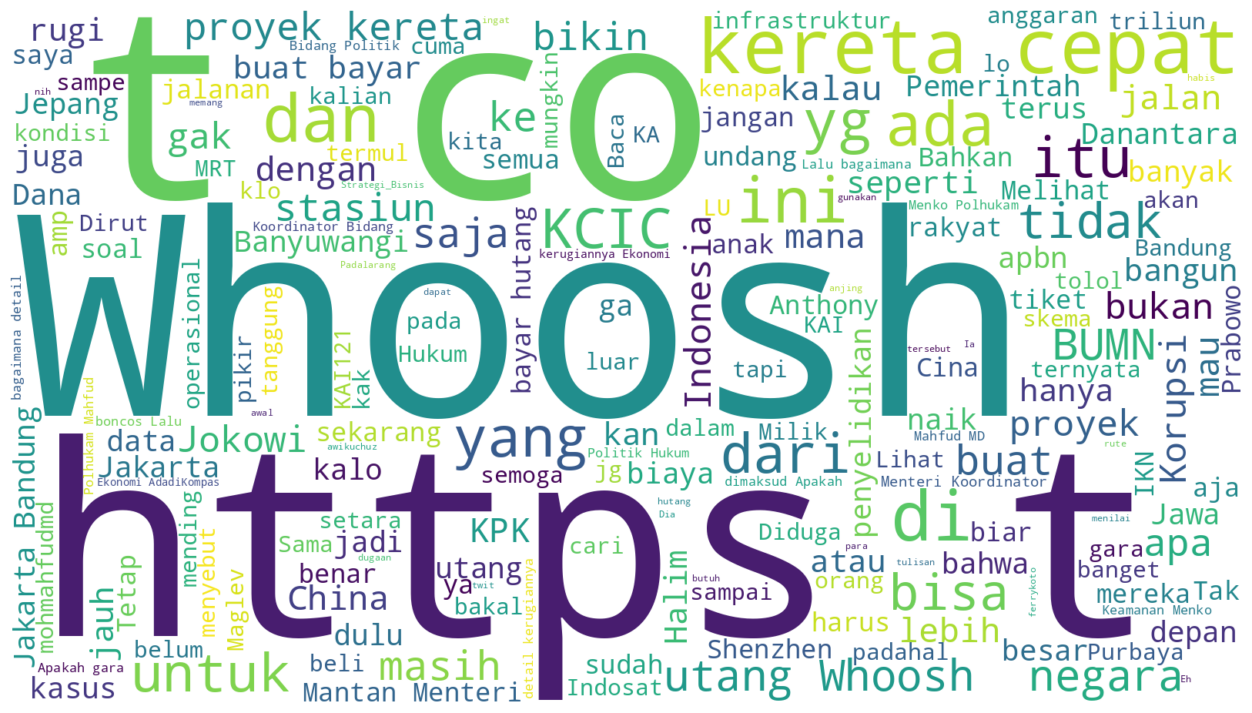

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = " ".join(df["text"].astype(str).tolist())

wc = WordCloud(
    width=1600,
    height=900,
    background_color="white",
    colormap="viridis"
).generate(all_text)

plt.figure(figsize=(16,9))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


In [16]:

df_to_txt = df_final[["created_at", "tweet_id", "text", "Evaluation", "Prob"]]

# Nama file
filename = "Crawling KCIC Twitter.txt"

# Tulis ke file .txt
with open(filename, "w", encoding="utf-8") as f:
    f.write("Tweet Analysis Output\n")
    f.write("=======================================\n\n")

    for idx, row in df_to_txt.iterrows():
        f.write(f"Row {idx+1}\n")
        f.write(f"Date       : {row['created_at']}\n")
        f.write(f"Tweet ID   : {row['tweet_id']}\n")
        f.write(f"Text (ID)  : {row['text']}\n")
        f.write(f"Sentiment  : {row['Evaluation']}\n")
        f.write(f"Prob       : {row['Prob']}\n")
        f.write("---------------------------------------\n\n")

print(f"TXT saved as: {filename}")

TXT saved as: Crawling KCIC Twitter.txt
